## YCSB-B

operationcount=40000000, cache_size=34359738368, threads=4
1567(b) 1568(b) 1569(b) 1570(b) 1571(b) 
operationcount=40000000, cache_size=34359738368, threads=8
1572(b) 1573(b) 1574(b) 1575(b) 1576(b) 
operationcount=40000000, cache_size=34359738368, threads=16
1577(b) 1578(b) 1579(b) 1580(b) 1581(b) 


,conf_id,workload,cache_size,rm_ratio,threads,version,runtime,throughput,throughput(%)
0,1567,b,34359738368,0.00,4,debug-v0,294.6180,135769.0,100.000000
1,1568,b,34359738368,0.10,4,debug-v0,345.5530,115757.0,85.260258
2,1569,b,34359738368,0.25,4,debug-v0,333.8690,119807.0,88.243266
3,1570,b,34359738368,0.50,4,debug-v0,338.6380,118120.0,87.000714
4,1571,b,34359738368,0.75,4,debug-v0,361.8070,110556.0,81.429487
5,1572,b,34359738368,0.00,8,debug-v0,158.3410,252620.0,100.000000
6,1573,b,34359738368,0.10,8,debug-v0,173.0600,231133.0,91.494339
7,1574,b,34359738368,0.25,8,debug-v0,173.3250,230780.0,91.354604
8,1575,b,34359738368,0.50,8,debug-v0,186.5210,214453.0,84.891537
9,1576,b,34359738368,0.75,8,debug-v0,191.2110,209193.0,82.809358


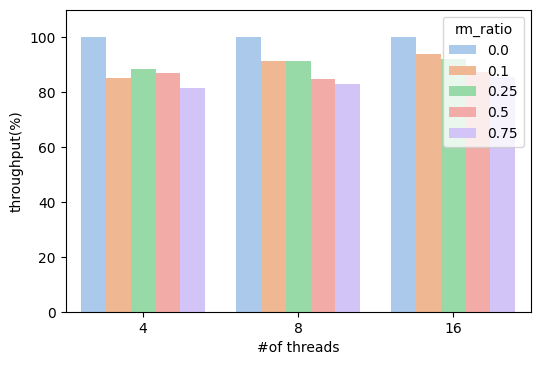

operationcount=40000000, cache_size=68719476736, threads=4
skip(1582) skip(1583) skip(1584) skip(1585) skip(1586) 
operationcount=40000000, cache_size=68719476736, threads=8
skip(1587) skip(1588) skip(1589) skip(1590) skip(1591) 
operationcount=40000000, cache_size=68719476736, threads=16
skip(1592) skip(1593) skip(1594) skip(1595) skip(1596) 


<Figure size 432x288 with 0 Axes>

In [6]:
import yaml
from exprmngr import ExprMngr
from ycsb_exprmngr import DB_PATH, parse_log
import seaborn as sns
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np

table_def = yaml.load(open('etc/table_def.yaml').read(), Loader=yaml.SafeLoader)
config = yaml.load(open('etc/config.yaml').read(), Loader=yaml.SafeLoader)
mngr = ExprMngr(table_def, DB_PATH, config)

workload = 'b'
zipfian_alpha = 0.99
requestdistribution = 'zipfian'
max_write_buffer_number = 4
min_write_buffer_number_to_merge = max_write_buffer_number - 2
max_background_jobs = 8
table_cache_numshardbits = 6
write_buffer_size = 256*1024**2
recordcount = 134217728
operationcount = 40000000
version = 'debug-v0'

ax_id = 0
data_df = None
for cache_size in [32*1024**3,64*1024**3]:
    for threads in [4,8,16]:
        print(f'{operationcount=}, {cache_size=}, {threads=}')
        inner_data_df = None
        for rm_ratio in [0.0,0.1,0.25,0.5,0.75]:
            conf_id = mngr.get_id(workload=workload, recordcount=recordcount, operationcount=operationcount, threads=threads, write_buffer_size=write_buffer_size, cache_size=cache_size, version=version, zipfian_alpha=zipfian_alpha, requestdistribution=requestdistribution,max_write_buffer_number=max_write_buffer_number,max_background_jobs=max_background_jobs, table_cache_numshardbits=table_cache_numshardbits,min_write_buffer_number_to_merge=min_write_buffer_number_to_merge, rm_ratio=rm_ratio)
            if not osp.exists(mngr.get_local_log_path(conf_id)):
                print(f'skip({conf_id})', end=' ')
                continue
            try:
                single_dict = parse_log(mngr.get_local_log_path(conf_id))
            except:
                print(f'skip({conf_id}({workload}))', end=' ')
                continue
            print(f'{conf_id}({workload})', end=' ')
            single_dict['workload'] = workload
            single_dict['cache_size'] = cache_size
            single_dict['rm_ratio'] = rm_ratio
            single_dict['threads'] = threads
            single_dict['version'] = version
            single_dict['conf_id'] = conf_id
            single_df = pd.DataFrame([single_dict])
            inner_data_df = single_df if inner_data_df is None else pd.concat([inner_data_df, single_df], ignore_index=True)
        if inner_data_df is not None:
            inner_data_df['throughput(%)'] = inner_data_df['throughput'] / inner_data_df['throughput'].max() * 100
            data_df = inner_data_df if data_df is None else pd.concat([data_df, inner_data_df], ignore_index=True)
        print()
    if data_df is None:
        continue
    data_df = data_df[['conf_id', 'workload', 'cache_size', 'rm_ratio', 'threads', 'version', 'runtime', 'throughput', 'throughput(%)']]
    fig = plt.figure(dpi=100)
    display(data_df)
    ax = plt.gca()
    y_label = 'throughput(%)'
    sns.barplot(x='threads', y=y_label, hue='rm_ratio', data=data_df, ax=ax, palette=sns.color_palette("pastel"))
    ax.set_ylim(0, data_df[y_label].max() * 1.1)
    ax.set_xlabel('#of threads')
    ax.set_ylabel(y_label if y_label.endswith('(%)') else 'throughput(ops/s)')
    mngr.conn.commit()
    data_df = None
    plt.show()
plt.tight_layout()

## YCSB-C

operationcount=40000000, cache_size=34359738368, threads=4
1423(c) 1424(c) 1425(c) 1426(c) 1427(c) 
operationcount=40000000, cache_size=34359738368, threads=8
1428(c) 1429(c) 1430(c) 1431(c) 1432(c) 
operationcount=40000000, cache_size=34359738368, threads=16
1433(c) 1434(c) 1435(c) 1436(c) 1437(c) 


,conf_id,mtime,workload,cache_size,rm_ratio,threads,version,runtime,throughput,throughput(%)
0,1423,2022-05-14 05:43,c,34359738368,0.00,4,debug-v0,172.5290,231845.0,100.000000
1,1424,2022-05-14 05:57,c,34359738368,0.10,4,debug-v0,192.8690,207395.0,89.454161
2,1425,2022-05-14 06:11,c,34359738368,0.25,4,debug-v0,197.9750,202046.0,87.147016
3,1426,2022-05-14 06:24,c,34359738368,0.50,4,debug-v0,202.2110,197813.0,85.321228
4,1427,2022-05-14 07:47,c,34359738368,0.75,4,debug-v0,237.5000,168421.0,72.643792
5,1428,2022-05-14 15:49,c,34359738368,0.00,8,debug-v0,83.6407,478236.0,100.000000
6,1429,2022-05-14 15:56,c,34359738368,0.10,8,debug-v0,95.6445,418215.0,87.449502
7,1430,2022-05-14 16:03,c,34359738368,0.25,8,debug-v0,100.3450,398624.0,83.352989
8,1431,2022-05-14 16:11,c,34359738368,0.50,8,debug-v0,103.8390,385211.0,80.548307
9,1432,2022-05-14 17:43,c,34359738368,0.75,8,debug-v0,119.9240,333546.0,69.745063


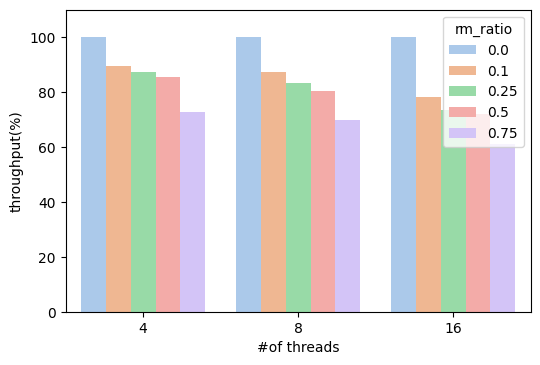

operationcount=40000000, cache_size=68719476736, threads=4
1393(c) 1394(c) 1395(c) 1396(c) 1397(c) 
operationcount=40000000, cache_size=68719476736, threads=8
1443(c) 1444(c) 1445(c) 1446(c) 1447(c) 
operationcount=40000000, cache_size=68719476736, threads=16
1398(c) 1399(c) 1400(c) 1401(c) 1402(c) 


,conf_id,mtime,workload,cache_size,rm_ratio,threads,version,runtime,throughput,throughput(%)
0,1393,2022-05-14 04:05,c,68719476736,0.00,4,debug-v0,132.2700,302411.0,100.000000
1,1394,2022-05-14 04:18,c,68719476736,0.10,4,debug-v0,158.5310,252317.0,83.435126
2,1395,2022-05-14 04:30,c,68719476736,0.25,4,debug-v0,181.7010,220141.0,72.795302
3,1396,2022-05-14 04:44,c,68719476736,0.50,4,debug-v0,173.0760,231112.0,76.423146
4,1397,2022-05-14 04:59,c,68719476736,0.75,4,debug-v0,213.4690,187381.0,61.962362
5,1443,2022-05-14 05:04,c,68719476736,0.00,8,debug-v0,69.2710,577442.0,100.000000
6,1444,2022-05-14 05:10,c,68719476736,0.10,8,debug-v0,311.2900,385493.0,66.758739
7,1445,2022-05-10 03:33,c,68719476736,0.25,8,debug-v0,101.0100,395999.0,68.578143
8,1446,2022-05-10 03:41,c,68719476736,0.50,8,debug-v0,106.1630,376780.0,65.249843
9,1447,2022-05-10 03:50,c,68719476736,0.75,8,debug-v0,130.7020,306040.0,52.999262


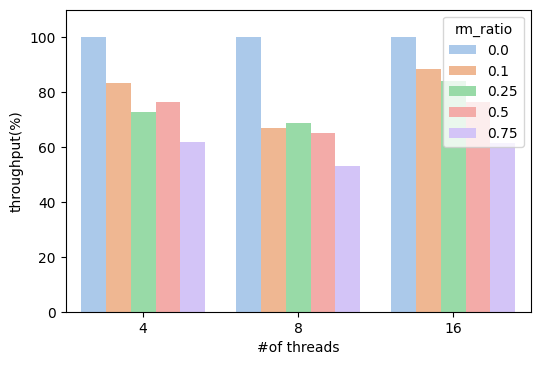

<Figure size 432x288 with 0 Axes>

In [7]:
import yaml
from exprmngr import ExprMngr
from ycsb_exprmngr import DB_PATH, parse_log
import seaborn as sns
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np

table_def = yaml.load(open('etc/table_def.yaml').read(), Loader=yaml.SafeLoader)
config = yaml.load(open('etc/config.yaml').read(), Loader=yaml.SafeLoader)
mngr = ExprMngr(table_def, DB_PATH, config)

zipfian_alpha = 0.99
requestdistribution = 'zipfian'
max_write_buffer_number = 4
max_background_jobs = 8
workload = 'c'
min_write_buffer_number_to_merge = max_write_buffer_number - 2
write_buffer_size = 256*1024**2
recordcount = 134217728
table_cache_numshardbits = 6
version = 'debug-v0'
operationcount = 40000000

data_df = None
for cache_size in [32*1024**3,64*1024**3]:
    for threads in [4,8,16]:
        print(f'{operationcount=}, {cache_size=}, {threads=}')
        inner_data_df = None
        for rm_ratio in [0.0,0.1,0.25,0.5,0.75]:
            conf_id = mngr.get_id(workload=workload, recordcount=recordcount, operationcount=operationcount, threads=threads, write_buffer_size=write_buffer_size, cache_size=cache_size, version=version, zipfian_alpha=zipfian_alpha, requestdistribution=requestdistribution,max_write_buffer_number=max_write_buffer_number,max_background_jobs=max_background_jobs, table_cache_numshardbits=table_cache_numshardbits,min_write_buffer_number_to_merge=min_write_buffer_number_to_merge, rm_ratio=rm_ratio)
            if not osp.exists(mngr.get_local_log_path(conf_id)):
                print(f'skip({conf_id})', end=' ')
                continue
            try:
                single_dict = parse_log(mngr.get_local_log_path(conf_id))
            except:
                print(f'skip({conf_id}({workload}))', end=' ')
                continue
            print(f'{conf_id}({workload})', end=' ')
            single_dict['workload'] = workload
            single_dict['cache_size'] = cache_size
            single_dict['rm_ratio'] = rm_ratio
            single_dict['threads'] = threads
            single_dict['version'] = version
            single_dict['conf_id'] = conf_id
            single_df = pd.DataFrame([single_dict])
            inner_data_df = single_df if inner_data_df is None else pd.concat([inner_data_df, single_df], ignore_index=True)
        if inner_data_df is not None:
            inner_data_df['throughput(%)'] = inner_data_df['throughput'] / inner_data_df['throughput'].max() * 100
            data_df = inner_data_df if data_df is None else pd.concat([data_df, inner_data_df], ignore_index=True)
        print()
    if data_df is None:
        continue
    data_df = data_df[['conf_id', 'mtime', 'workload', 'cache_size', 'rm_ratio', 'threads', 'version', 'runtime', 'throughput', 'throughput(%)']]
    fig = plt.figure(dpi=100)
    display(data_df)
    ax = plt.gca()
    y_label = 'throughput(%)'
    sns.barplot(x='threads', y=y_label, hue='rm_ratio', data=data_df, ax=ax, palette=sns.color_palette("pastel"))
    ax.set_ylim(0, data_df[y_label].max() * 1.1)
    ax.set_xlabel('#of threads')
    ax.set_ylabel(y_label if y_label.endswith('(%)') else 'throughput(ops/s)')
    mngr.conn.commit()
    data_df = None
    plt.show()
plt.tight_layout()